## Plan:

* Used optimized code on mnist
* Use on real data (UCI)


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, prange

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.datasets import fetch_olivetti_faces
import itertools as it 
from tqdm.notebook import tqdm, trange

from mlxtend.data import loadlocal_mnist
from functools import partial
import pandas as pd
import glob
from skimage import color, io

np.random.seed(1234)

In [2]:
import requests, tarfile, os, gzip, shutil, zipfile

Start with functions that do not need wrappers (e.g. no JIT layer) or no optimization. The variable `optim` will only ever take values in {"none", "fast", "fastest"}.

In [3]:
def pca(X, k = 30, optim = "fastest"):
    """Use PCA to project X to k dimensions."""
    
    # Center/scale the data.
    s = np.std(X, axis=0)
    s = np.where(s==0, 1, s)
    X = (X - np.mean(X, axis=0))/s

    if optim == "none":
        # Compute covariance eigenvectors with numpy.
        _, U = np.linalg.eigh(X.T@X)
        print("Custom PCA is broken; defaulting to sklearn.")
        #return X@U[:,:k]
        pca_ = PCA(n_components=k)
        return pca_.fit_transform(X)
    else:
        # Run PCA with sklearn.
        pca_ = PCA(n_components=k)
        return pca_.fit_transform(X)


def get_dists(X, optim = "fastest"):
    """Return squared Euclidean pairwise distances."""
    
    if optim == "none":
        n = X.shape[0]
        dists = np.zeros([n, n])
        
        for i in range(n):
            for j in range(i, n):
                dists[i, j] = np.sum((X[i, :] - X[j, :])**2)
 
        return dists + dists.T
    else:
        return pairwise_distances(X, metric="sqeuclidean")
    
    
def entropy(p):    
    """Calculates 2 ** H(p) of array p, where H(p) is the Shannon entropy."""
    return 2 ** np.sum(-p*np.log2(p+1e-10))
    
    
def get_Y_dists(Y, optim = "fastest"):
    """Takes in an n*n matrix Y, returns a matrix of (1+||y_i-y_j||^2)^-1."""
    D = get_dists(Y, optim = optim)
    return np.power(1 + D, -1)
    

def get_Q(Y_dists):
    """Normalize a matrix excluding the diagonal."""
    np.fill_diagonal(Y_dists, 0)
    return Y_dists/np.sum(Y_dists)

Two versions of binary search. I don't think we'll be able to do this in parallel with numba; compiling a function that takes in functions seems painful. **Can we use a different library?**

In [4]:
def binary_search_py(f, val, lb=0, ub=1e4, tol=1e-6, maxit=250):
    """Simple Python implementation of binary search."""
    
    for i in range(maxit):
        midpoint = (lb + ub)/2
        score = f(midpoint)
        
        if score < val:
            lb = midpoint
        else:
            ub = midpoint

        if np.abs(score-val) < tol:
            return midpoint 
        
    return midpoint


def binary_search_numba(f, val, lb=0, ub=1e4, tol=1e-6, maxit=250):
    """Compiled implementation of binary search.
    
    Concern: numba might explode if we try to give it a function as an argument."""
        
    return binary_search_py(f, val, lb, ub, tol, maxit)


def binary_search(f, val, lb=0, ub=1e4, tol=1e-6, maxit=250, optim = "none"):
    """
    Executes binary search to find the input x with |f(x) - val| < tol.
    
    Inputs:
        f - function to be paramterized for val
        val - desired score
        lb  - lower bound for search
        ub  - upper bound for search
        tol - tolerance
        maxit - maximum number of iterations
        optim - "none", "fast", or "fastest". Which level of optimization to run.
        
    Output:
        midpoint - value such that the score of fx is within given tolerance of val
    """
    
    if optim == "none":
        return binary_search_py(f, val, lb, ub, tol, maxit)
    else:
        return binary_search_numba(f, val, lb, ub, tol, maxit)

Two versions of the affinity function.

In [5]:
def get_pji_py(D, sigma, i):
    """Find conditional probabilities in raw Python."""

    return get_pji_numpy(D, sigma, i)


def get_pji_numpy(D, sigma, i):
    """Find conditional probabilities with broadcasting."""
    
    scale = 2*sigma**2
        
    D_scaled = -D.copy()/scale
    D_scaled -= np.max(D_scaled)
    exp_D = np.exp(D_scaled)
    exp_D[i] = 0
    
    return exp_D/np.sum(exp_D)


def get_pji(D, sigma, i, optim = "fastest"):
    """
    Compute conditional probabilities from a single row of distances..
    
    Inputs:
        D - 1xN row vector from a pairwise distance matrix D
        sigma - std of a Guassian used for conditional probabilities
        optim - "none", "fast", or "fastest". Which level of optimization to run.
        
    Output:
        pj_i - 1xN vector of conditional probabilities
    """
    
    if optim == "none":
        return get_pji_py(D, sigma, i)
    else:
        return get_pji_numpy(D, sigma, i)

Two versions to get the perplexities. This might be a giant headache to get working with numba. Maybe leave this until the end? It only runs once.

In [6]:
def get_P_py(D, perp = 30, lb = 0, ub = 1e4, tol = 1e-6, maxit = 250):
    """Optimize variances to perplexities using raw python."""
    
    N = D.shape[0]
    P = np.zeros((N,N))
    
    for i in range(N):
        f = lambda x: entropy(get_pji_py(D[i, :], sigma=x, i = i))
        sig = binary_search_py(f, val=perp, lb=lb, ub=ub, tol=tol, maxit=maxit)
        P[i, :] = get_pji_py(D[i,:], sig, i = i)
    
    return (P + P.T) / (2*N)


def get_P_numba(D, perp = 30, lb = 0, ub = 1e4, tol = 1e-6, maxit = 250):
    """
    Do the above, but with numba binary search and parallel range. To be done.
    
    CRITICAL: THIS SHOULD CALL binary_search_numba, NOT binary_search_py,
              AS WELL AS get_pji_numpy, NOT get_pji_py.
    """
    
    return get_P_py(D, perp = 30, lb = 0, ub = 1e4, tol = 1e-6, maxit = 250)


def get_P(D, perp = 30, lb = 0, ub = 1e4, tol = 1e-6, maxit = 250, optim = "fastest"):
    """
    Generates NxN symmetric affinity score matrix from pairwise distances.
    
    Input:
        D -  pairwise distance matrix.
        perp - target perplexity of conditional probabilies pj_i
        lb - lower bound in binary search 
        ub - upper bound in binary search
        tol - tolerance in binary search
        maxit - maximum  iterations in binary search
        optim - "none", "fast", or "fastest". Which level of optimization to run.
                
    Output:
        P - NxN symmetric affinity score matrix 
    """
    
    if optim == "none":
        return get_P_py(D, perp, lb, ub , tol, maxit)
    else:
        return get_P_numba(D, perp, lb, ub , tol, maxit)

Now the gradient. Concern with making this parallel: we're applying operations to rows of an array, not collecting operations to a single quantity. Might not give any speedup. 

**Update: using njit with parallel was 3x slower. Changing it to jit is now slightly faster.**

In [7]:
def grad_py(R, Y_dists, Y):
    """Compute the t-SNE gradient with raw Python."""
    
    n = Y.shape[0]
    dY = np.zeros(shape = Y.shape)
    
    for i in range(n):
        for j in range(n):
            #dY[i,:] += 4*R[i,j]*(Y[i, :] - Y[j, :])*Y_dists[i, j]
            
            for k in range(Y.shape[1]):
                dY[i,k] += 4*R[i,j]*(Y[i, k] - Y[j, k])*Y_dists[i, j]

    return dY
    

def grad_numpy(R, Y_dists, Y):
    """Compute the t-SNE gradient with vectorization."""
    dY = np.zeros_like(Y)

    for i in range(Y.shape[0]):
        # Write the sum as a dot product of a vector and a matrix.
        dY[i,:] = 4*np.dot(R[i,:]*Y_dists[i,:], Y[i,:] - Y)
            
    return dY
    

@njit(parallel=True)
def grad_numba(R, Y_dists, Y):
    """Compute the t-SNE gradient in parallel."""
    
    n = Y.shape[0]
    d = Y.shape[1]
    dY = np.zeros(shape = Y.shape)
    
    for i in prange(n):
        for j in range(n):
            for k in prange(d):
                dY[i,k] += 4*R[i,j]*(Y[i, k] - Y[j, k])*Y_dists[i, j]

    return dY



def get_grad(R, Y_dists, Y, optim = "fast"):
    """Compute the t-SNE gradient.
    
    Inputs:
        R - n*n matrix of difference between high/low dimensional affinities.
        Y_dists - n*n matrix of embedded similarities.
        optim - "none", "fast", or "fastest". Which level of optimization to run.

    Outputs:
        dY - n*d matrix of t-SNE gradients."""
    
    if optim == "none":
        return grad_py(R, Y_dists, Y)
    elif optim == "fast":
        return grad_numpy(R, Y_dists, Y)
    else:
        return grad_numba(R, Y_dists, Y)

Some learning rates.

In [8]:
def constant(t, eta_init, last_eta, c = 100):
    """Constant learning rate."""
    return c


def time_based(t, eta_init, last_eta, d = 0.01):
    """Time-based learning rate with decay d."""
    return last_eta/(1+d*t)


def step_based(t, eta_init, last_eta, d = 0.01, r = 50):
    """Step-based learning rate with decay d and rate r."""
    return eta_init*d**np.floor((1+t)/r)


def exponential(t, eta_init, last_eta, d = 0.01):
    """Exponential  learning rate with decay d."""
    return eta_init*np.exp(-d*t)

Compile the C stuff before we start benchmarking.

In [9]:
P_test = np.array([[1,2,3],
             [4,5,6],
             [7,8,9]])

Q_test = np.array([[9,7,8],
             [3,1,2],
             [6,5,4]])

Y_test = np.array([[-0.5, 0.25],
             [-1, 2],
             [3, -6]])

P_test = P_test + P_test.T
Q_test = Q_test + Q_test.T
R_test = P_test - Q_test
Y_dists_test = get_Y_dists(Y_test)
_ = get_grad(R_test, Y_dists_test, Y_test, optim = "fastest")

%timeit get_grad(R_test, Y_dists_test, Y_test, optim = "none")
%timeit get_grad(R_test, Y_dists_test, Y_test, optim = "fast")
%timeit get_grad(R_test, Y_dists_test, Y_test, optim = "fastest")

66.7 µs ± 4.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
22.3 µs ± 886 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
25.6 µs ± 9.61 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Finally, t-SNE.

In [10]:
def tsne(X, niter = 1000, alpha_init = 0.5, alpha_final = 0.8, alpha_thr = 250, 
         eta_init = 100, lr_fun = constant, d = 2, exg = 4, exg_thr = 50, 
         perplexity = 30, pca_dims = 30, optim = "fast", verbose = True):
    """Run t-SNE.
    
    Required inputs: 
        X - NxM matrix
    
    Optional inputs:
        d - dimension of embedding
        perplexity - target perplexity
        niter - number of iterations
        alpha_int - initial value of momentum
        alpha_final - final value of momentum term
        alpha_thr - iteration when momentum changes
        eta_init - initial learning rate
        lr_fun - learning rate function
        exg - multiplicative factor for early exaggeration
        exg_thr - iteration to stop exaggeration
        pca_dims - maximum number of dimensions before preprocessing with PCA
        optim - "none", "fast", or "fastest". Which level of optimization to run
        verbose - bool, whether or not to print a progress bar
    
    Outputs:
        Y - (niter + 2) x N x d array of embeddings for each iteration"""
    
    #
    #
    # TO do - sanitize inputs.
    #
    #
    
    if X.shape[1] > pca_dims:
        # Reduce dimension if needed.
        X = pca(X, pca_dims, optim)
    
    # Get affinities with exaggeration.
    D = get_dists(X, optim)    
    pij = exg*get_P(D, perplexity, optim)
    
    # Initialize first few iterations.
    size = (pij.shape[0], d)
    Y = np.zeros(shape = (niter + 2, size[0], d))
    initial_vals = np.random.normal(0.0, np.sqrt(1e-4), size)
    Y[0, :, :] = Y_m1 = Y[1, :, :] = Y_m2 = initial_vals
    
    last_eta = eta_init
    alpha = alpha_init
    
    if verbose:
        #
        # Look at disable in trange
        # remove verbose stuff
        #
        iterator = trange(2, niter + 2)
    else:
        iterator = range(2, niter + 2)
    
    for i in iterator:
        if i == int(alpha_thr):
            # Reduce momentum after some time.
            alpha = alpha_final
        
        if i == int(exg_thr):
            # Stop the exaggeration.
            pij /= exg
        
        # Compute gradient.
        Y_dists = get_Y_dists(Y_m1, optim)
        qij = get_Q(Y_dists)
        rij = pij - qij
        grad = get_grad(rij, Y_dists, Y_m1, optim)
        
        # Update learning rate.
        eta = lr_fun(i, eta_init, last_eta)
        last_eta = eta
        
        # Update embeddings.
        Y_new = Y_m1 - eta*grad + alpha*(Y_m1 - Y_m2)
        Y_m2, Y_m1 = Y_m1, Y_new
        Y[i, :, :] = Y_new
    
    return Y

Current `optim="none"` takes ~5 minutes with 100 iterations.

## MNIST Data Visualization

In [11]:
# https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url
def get_uci(save_folder="./data/",  chunk_size=128):
    """Retreives PANCAN gene expression data from UCI ML repository
       Saves data within a folder called TCGA-PANCAN-HiSeq-801x20531.
       
       
       Required inputs: 
           data_folder - path to location where TCGA-PANCAN-HiSeq-801x20531 is saved
    
       Optional inputs:
           chunk_size ~ rate at which bytes are downloaded 
        
    """
    
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz"
    save_path = os.path.join(save_folder, "TCGA-PANCAN-HiSeq-801x20531.tar.gz")
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as f:
        print(f"Retrieving RNA-Seq (HiSeq) PANCAN data set from {url}\n")
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            
        print(f"Wrote tarfile to {save_path}\n")
    
    with tarfile.open(save_path) as f:
        print(f"Extracting tarfile to {save_folder}\n")
        f.extractall(dest)
        
    os.remove(save_path)
        
    
def get_humanM1_10x(data_folder="./data",  chunk_size=128):
    """Retreives gene expression data on single-nucleus transcriptomes from 2 post-mortem human brain specimen.
       The data were generated as part of a BICCN collaboration to characterize cell type diversity in M1 
       across species and data modalities. 
       
       Saves data within a folder called humanM1_10x.
       
       
       Required inputs: 
           data_folder - path to location where humanM1_10x is saved
    
       Optional inputs:
           chunk_size ~ rate at which bytes are downloaded 
    
    """
    
    folder_path = os.path.join(data_folder, "humanM1_10x")
    
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    
    gene_url = "https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/matrix.csv"
    meta_url = "https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/metadata.csv"
    
    save_path = os.path.join(folder_path, "matrix.csv")
    r = requests.get(gene_url, stream=True)
    with open(save_path, 'wb') as f:
        print(f"Retrieving gene expression data set from {gene_url}\n")
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            
        print(f"Wrote gene expression data to {save_path}\n")
    
    
    
    
    save_path = os.path.join(folder_path, "metadata.csv")
    r = requests.get(meta_url, stream=True)
    with open(save_path, 'wb') as f:
        print(f"Retrieving meta data for gene expression matrix from {gene_url}\n")
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            
        print(f"Wrote meta data to {save_path}\n")

In [12]:
def get_mnist(data_folder='./data', chunk_size=128):
    """Retreives images of mnist digits and corresponding labels
       Saves data within a folder called mnist.
       
       
       Required inputs: 
           data_folder - path to location where mnist is saved
    
       Optional inputs:
           chunk_size ~ rate at which bytes are downloaded 
    
    """
    
    
    folder_path = os.path.join(data_folder, "mnist")
    
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        
        
    url = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
    zip_path = os.path.join(folder_path, "train-images-idx3-ubyte.gz")
    image_bytes = os.path.join(folder_path, "train-images-idx3-ubyte")
    r = requests.get(url, stream=True)
    
    with open(zip_path, 'wb') as f:
        print(f"Retrieving MNIST images from {url}\n")
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            
        print(f"Wrote zipfile to {zip_path}\n")
    
    print(f"Extract {zip_path} to {image_bytes}")
    with gzip.open(zip_path, 'rb') as f_in:
        
        with open(image_bytes, 'wb') as f_out:
            f_out.write(f_in.read())

        
    # remove zip file
    os.remove(zip_path)
    
    url = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
    zip_path = os.path.join(folder_path, "train-labels-idx1-ubyte.gz")
    label_bytes = os.path.join(folder_path, "train-labels-idx1-ubyte")
    r = requests.get(url, stream=True)
    with open(zip_path, 'wb') as f:
        print(f"Retrieving MNIST labels from {url}\n")
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)

        print(f"Wrote zipfile to {label_bytes}\n")
    
    
    print(f"Extract {zip_path} to {label_bytes}")
    with gzip.open(zip_path, 'rb') as f_in:
        with open(label_bytes, 'wb') as f_out:
            f_out.write(f_in.read())

    
    # remove zip file
    os.remove(zip_path)
    
    
    # Load mnist data
    X, y = loadlocal_mnist(
            images_path=image_bytes, 
            labels_path=label_bytes)
    
    X_path = os.path.join(folder_path,"X_MNIST.npy")
    y_path = os.path.join(folder_path,"y_MNIST.npy")
    
    print(f"Saving MNIST images to {X_path}\n")
    np.save(X_path, X)
    
    print(f"Saving MNIST image labels to {y_path}\n")
    np.save(y_path, y)
    
    os.remove(image_bytes)
    os.remove(label_bytes)
    

In [32]:
get_mnist()

Retrieving MNIST images from http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz

Wrote zipfile to ./data/mnist/train-images-idx3-ubyte.gz

Extract ./data/mnist/train-images-idx3-ubyte.gz to ./data/mnist/train-images-idx3-ubyte
Retrieving MNIST labels from http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

Wrote zipfile to ./data/mnist/train-labels-idx1-ubyte

Extract ./data/mnist/train-labels-idx1-ubyte.gz to ./data/mnist/train-labels-idx1-ubyte


In [13]:
def get_coil20(data_folder='./data', chunk_size=128):
    """Retreives COIL-20 data of processed images.
       Saves data within a folder called coil-20.
       
       
       Required inputs: 
           data_folder - path to location where coil-20 is saved
    
       Optional inputs:
           chunk_size ~ rate at which bytes are downloaded 
    
    """
    
    url = "http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.zip"
    zipname = url.split('/')[-1]
    zip_path = os.path.join(data_folder, zipname)
    r = requests.get(url, stream=True)
    with open(zip_path, 'wb') as f:
        print(f"Retrieving COIL-20 images from {url}\n")
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            
        print(f"Wrote zipfile to {zip_path}\n")
    
    print(f"Extracting {zip_path}")
    with zipfile.ZipFile(zip_path, 'r') as f:
        f.extractall(data_folder)
    
    os.remove(zip_path)

In [14]:
def proc_coil20(data_folder='./data/coil-20-proc'):
    """Generates feature matrix for images from COIL-20 data set and extracts image labels
    from file names.
       Saves data within a folder called coil-20.
       
       
       Required inputs: 
           data_folder - path to location where coil-20 images are stored
    """
    
    globpath = os.path.join(data_folder, '*.png')
    file_names = list(map(os.path.basename, glob.glob(globpath)))
    labels = np.vstack([re.findall(r'([a-zA-Z]+\d+|\d+(?=\.))', file) for file in  file_names])
    
    label_path = os.path.join(data_folder, 'y_COIL.csv')
    np.savetxt(label_path, labels, fmt='%s')
    
    arrays = []
    for file_path in file_names:
        img_path = os.path.join(data_folder, file_path)
        img = io.imread(img_path)
        n,p = img.shape
        arrays.append(img.reshape((1, n*p)))
        
    image_path = os.path.join(data_folder, 'X_COIL.npy')
    np.save(image_path, np.vstack(arrays))
    

In [53]:
get_coil20()

Retrieving COIL-20 images from http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.zip

Wrote zipfile to ./data/coil-20-proc.zip

Extracting ./data/coil-20-proc.zip


In [15]:
def load_mnist(folderpath='./data/mnist', size=None):
    """Loads mnist data set
    
    Required inputs: 
        folderpath - to folder with coild20 data
    
    Optional inputs:
        size ~ sample size 
    
    Outputs:
        X ~ pixel data for mnist dat
        Y - digit labels correponding to 
    
    """
    
    data_path = os.path.join(folderpath, 'X_MNIST.npy')
    label_path = os.path.join(folderpath, 'y_MNIST.npy')
    X = np.load(data_path)
    Y = np.load(label_path)
    
    if isinstance(size, int):
        index = np.random.choice(np.arange(Y.size), size=size)
        
        return X[index, :], Y[index]
        
    
    return X,Y


In [35]:
def load_coil20(folderpath='./data/coil-20-proc', size=None):
    """Loads coil-20 data set
    
    Required inputs: 
        folderpath - to folder with mnist data
    
    Optional inputs:
        size ~ sample size 
    
    Outputs:
        X ~ pixel data for coil 20 images
        Y - image labels correponding to 
    
    """
    
    data_path = os.path.join(folderpath, 'X_COIL.npy')
    label_path = os.path.join(folderpath, 'y_COIL.npy')
    X = np.load(data_path)
    Y = np.genfromtxt(label_path, dtype='str')

    
    if isinstance(size, int):
        index = np.random.choice(np.arange(X.shape[0]), size=size)
        
        return X[index, :], Y[index, :]
        
    
    return X,Y

In [88]:
def load_UCI(folderpath='./TCGA-PANCAN-HiSeq-801x20531', size=None):
    """Loads PANCAN atlas data from UCI
    
    Required inputs: 
        folderpath - to folder with UCI RNA gene expression data
    
    Optional inputs:
        size ~ sample size 
    
    Outputs:
        X ~ gene expressions
        Y - type of tumor
    
    """
    
    data_path = os.path.join(folderpath, 'data.csv')
    label_path = os.path.join(folderpath, 'labels.csv')
    
    X = pd.read_csv(data_path)
    Y = pd.read_csv(label_path)

    
    samples = X[["Unnamed: 0"]]
    
    # Merge sample ids to meta_data to get class labels 
    samples = samples.merge(Y, how="left", on="Unnamed: 0")
    
    if isinstance(size, int):
        index = np.random.choice(np.arange(Y.size), size=size)
        
        return X.values[index, 1:].astype(int), samples.Class.values[index]
        
    
    return X.values[:, 1:].astype(int), samples.Class.values

In [18]:
def load_humanM1(folderpath='./data/humanM1_10x', nrows=3000):
    """Loads human M1 10x data
    
    Required inputs: 
        folderpath - to folder with UCI RNA gene expression data
    
    Optional inputs:
        size ~ sample size 
    
    Outputs:
        X ~ gene expressions
        Y - type of tumor
    
    """
    
    data_path = os.path.join(folderpath, 'matrix.csv')
    label_path = os.path.join(folderpath, 'metadata.csv')
    
    data = pd.read_csv(data_path, nrows = nrows)
    meta_data = pd.read_csv(label_path)
    
    #  Extract sample ids from gene expression matrix
    labels = data[["sample_name"]]  
    
    # Merge sample ids to meta_data to get class labels 
    labels = labels.merge(meta_data, how="left", on="sample_name")
    
    return data.values[:,1:].astype(int), labels.class_label.values

In [ ]:
get_uci()

In [40]:
get_humanM1_10x()

Retrieving gene expression data set from https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/matrix.csv

Wrote gene expression data to ./data/humanM1_10x/matrix.csv

Retrieving meta data for gene expression matrix from https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/matrix.csv

Wrote meta data to ./data/humanM1_10x/metadata.csv



### Plotting function 

In [84]:
def compare_methods(data_list: list, label_list: list, data_names: list, fmt_list: list,
                    legends=[True, True, True], niter=1000, verbose=False, n_neighbors = 20):
    """Runs tsne, pca, and isomap on a list of n data sets and compares results in a 3xn panel plot.
    
    Required inputs: 
        data_list  - list of data sets
        label_list - list of labels corresponding to data set
        fmt_list   - list of dictionaries that map labels to color and shape for scatter plots 
    
    Optional inputs:
        legends       - list of booleans indicating where to use legend for plots corresponding to dataset
        niter         - number of iterations for tsne
        alpha_int     - initial value of momentum
        verbose       - bool, whether or not to print a progress bar
        n_neighbors   - number of neighbors to use in isomap
    
    Outputs:
        Y - 3xn panel plot
    """
    
    methods = {"T-SNE": tsne, "PCA": pca, "Isomap": Isomap}
    params =  {"T-SNE" : {"niter" : niter, "optim" : "fastest", "verbose" : verbose},
               "PCA"   : {"k" : 2},
               "Isomap": {"n_neighbors" : n_neighbors, "n_components" : 2}
              }

    nrows =  len(methods)
    ncols =  len(data_list)
    
    
    # Configure axes
    axes = []
    fig = plt.figure(figsize = (12, 3 * nrows))
    
    for ind1, X in enumerate(data_list):
        fmt_dict = fmt_list[ind1]
        labs = label_list[ind1]
        for ind2, method in enumerate(methods):
            
            embedding = partial(methods[method], **params[method]) 
            
            if method=="T-SNE":
                low_d = embedding(X)
                low_d = low_d[-1,:,:]

            elif method=="Isomap":
                iso  = embedding()
                low_d = iso.fit_transform(X)

            else:
                low_d = embedding(X) 

  
            axes.append(fig.add_subplot(nrows, ncols, 1 + ind1 + (ind2)*ncols))
            if ind2 == 0:
                axes[-1].set_title(data_names[ind1],
                                   fontdict={'size':24, 'fontweight':'normal'})
                
            if ind1 == 0:
                axes[-1].set_ylabel(method, 
                                    rotation=0,
                                    fontdict={'size':18, 'fontweight':'normal'})
                axes[-1].yaxis.set_label_coords(-0.2,.8)

            for lab in fmt_dict.keys():
                index = labs == lab
                fmt = fmt_dict[lab]
                axes[-1].scatter(low_d[index,0], low_d[index,1], alpha=0.8, 
                                 c=fmt['c'], marker = fmt['m'],
                                 edgecolors='none', s=30, label=lab)

            if (ind2 + 1 == nrows) and legends[ind1]==True:
                axes[-1].legend(loc='best', 
                        fancybox=False, shadow=False, ncol=1)

            axes[-1].set_xticklabels([])
            axes[-1].set_yticklabels([])
            axes[-1].xaxis.set_ticks_position('none')
            axes[-1].yaxis.set_ticks_position('none')
            

            

    fig.subplots_adjust(bottom=0.3, wspace=0.33)    
    fig.tight_layout()    
    
    
    
# https://stackoverflow.com/questions/46266700/how-to-add-legend-below-subplots-in-matplotlib

In [76]:
def gen_fmt_dict(y, colors, shapes):
    """Assigns colors to unique labels
    
       Required Inputs:
    
       y ~ vector of labels
       colors ~ list of colors
       
       
       Output:
       Dictionary mapping class label to color
    """
    
    return  {g[0]: {'c' : g[1][1], 'm' : g[1][0]} for g in zip(np.sort(np.unique(y)), it.product(shapes, colors))}
    

### Panel Plots

In [ ]:
Xm, ym = load_mnist(size=1000)
Xc, Yc = load_coil20(size=1000)
yc = Yc[:,0]
olivetti = fetch_olivetti_faces()
Xo = olivetti.datapaper
yo = olivetti.target

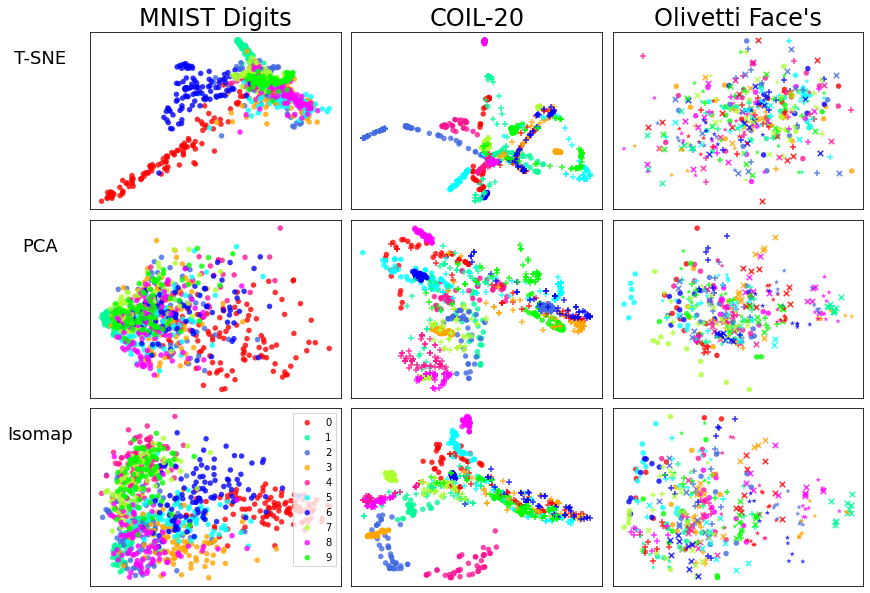

In [86]:
colors = ['red', 'mediumspringgreen', 'royalblue','orange' ,'deeppink',
          'aqua','blue', 'greenyellow' ,'fuchsia', 'lime']
shapes = ['o', '+', 'x', '*', 'D', 'p']

fmt_list = [gen_fmt_dict(y, colors, shapes) for y in [ym, yc, yo]]

titles = ["MNIST Digits", "COIL-20", "Olivetti Face's"]
legends = [True, False, False]

compare_methods(data_list=[Xm, Xc, Xo], label_list=[ym, yc, yo], data_names=titles, 
            fmt_list=fmt_list, legends=legends, niter=10)

In [91]:
Xcan, ycan = load_UCI()
Xm1, ym1   = load_humanM1(nrows=500)

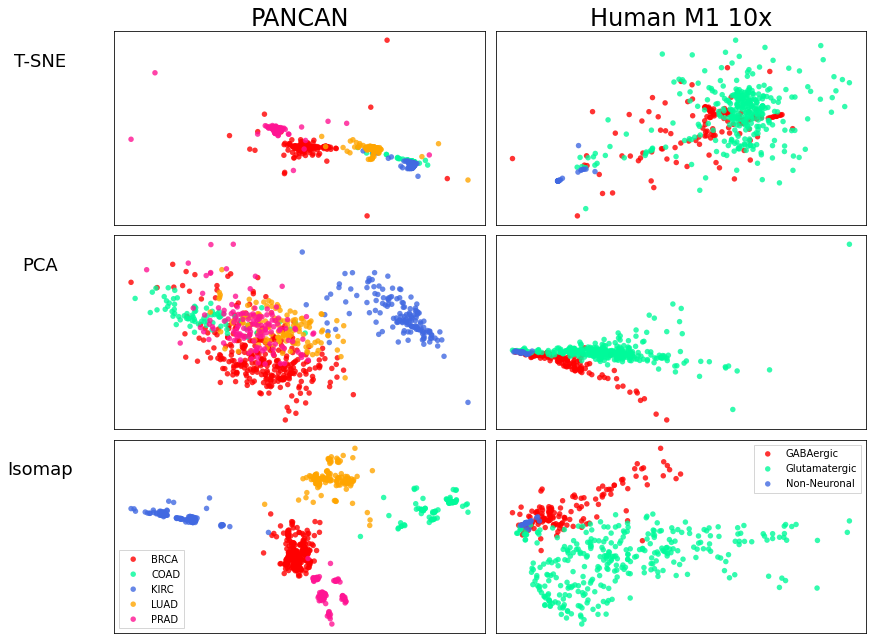

In [92]:
colors = ['red', 'mediumspringgreen', 'royalblue','orange' ,'deeppink',
          'aqua','blue', 'greenyellow' ,'fuchsia', 'lime']
shapes = ['o', '+', 'x', '*', 'D', 'p']

fmt_list = [gen_fmt_dict(y, colors, shapes) for y in [ycan, ym1]]

titles = ["PANCAN", "Human M1 10x"]
legends = [True, True]

compare_methods(data_list=[Xcan, Xm1], label_list=[ycan, ym1], data_names=titles, 
            fmt_list=fmt_list, legends=legends, niter=10)